<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**




**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [ ]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [ ]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (m² por habitante de Zonas Verdes)

### Preparacion de datos

In [ ]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','m² por habitante']]

In [ ]:
df_cont = df_sel.dropna()

In [ ]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7008 entries, 0 to 7007
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   7008 non-null   int64  
 1   Trimestre             7008 non-null   int64  
 2   Mes                   7008 non-null   int64  
 3   Codi_Districte        7008 non-null   int64  
 4   Nom_Districte         7008 non-null   object 
 5   Codi_Barri            7008 non-null   int64  
 6   Nom_Barri             7008 non-null   object 
 7   Compraventa_Unitario  7008 non-null   float64
 8   m² por habitante      7008 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 547.5+ KB


In [ ]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [ ]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [ ]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,m² por habitante
Fecha,,,,,,,,,
2014-01-01,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,6.2
2014-02-01,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,6.2
2014-03-01,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,6.2
2014-04-01,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,6.2
2014-05-01,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,6.2


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [ ]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [ ]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [ ]:
df.head()

,Compraventa_Unitario,m² por habitante
Fecha,,
2014-01-01,1511.900000,6.9
2014-02-01,1511.900000,6.9
2014-03-01,1511.900000,6.9
2014-04-01,1633.069231,6.9
2014-05-01,1633.069231,6.9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2014-01-01 to 2021-12-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  96 non-null     float64
 1   m² por habitante      96 non-null     float64
dtypes: float64(2)
memory usage: 2.2 KB


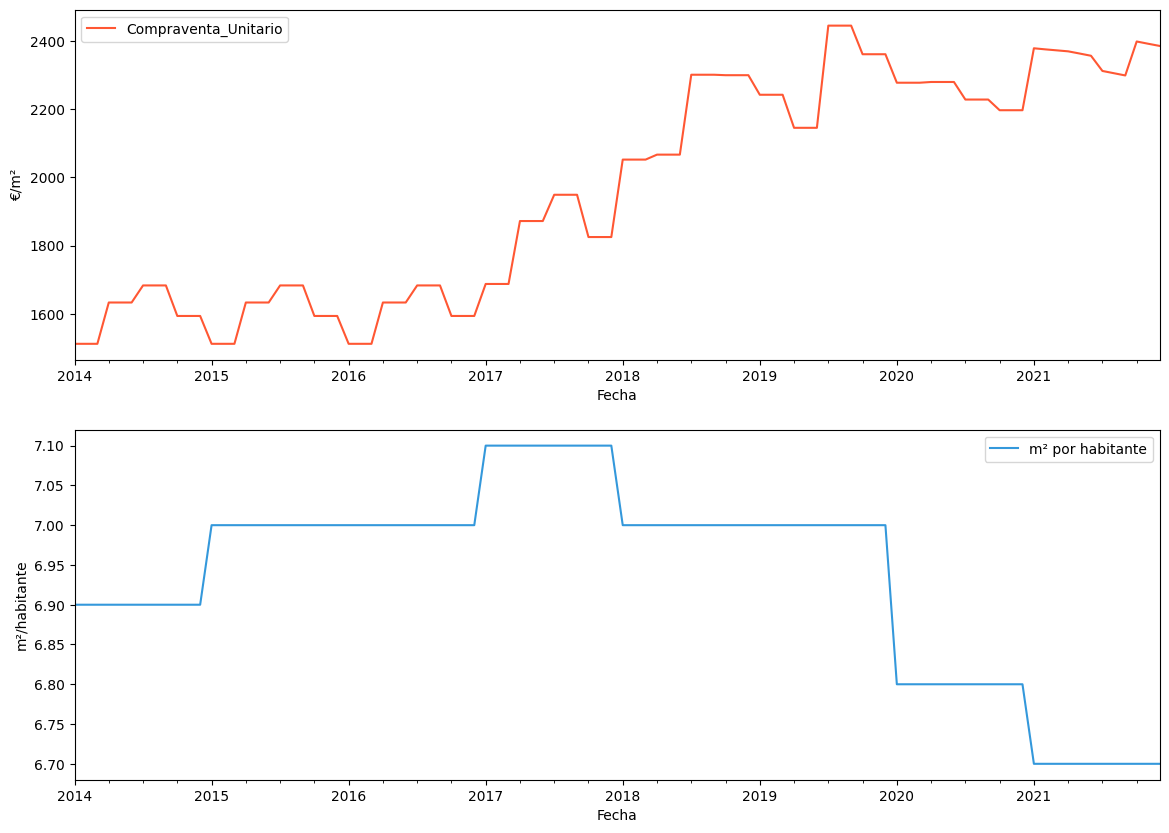

In [ ]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²','m²/habitante']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [ ]:
corr=df.corr()
corr

,Compraventa_Unitario,m² por habitante
Compraventa_Unitario,1.000000,-0.475285
m² por habitante,-0.475285,1.000000


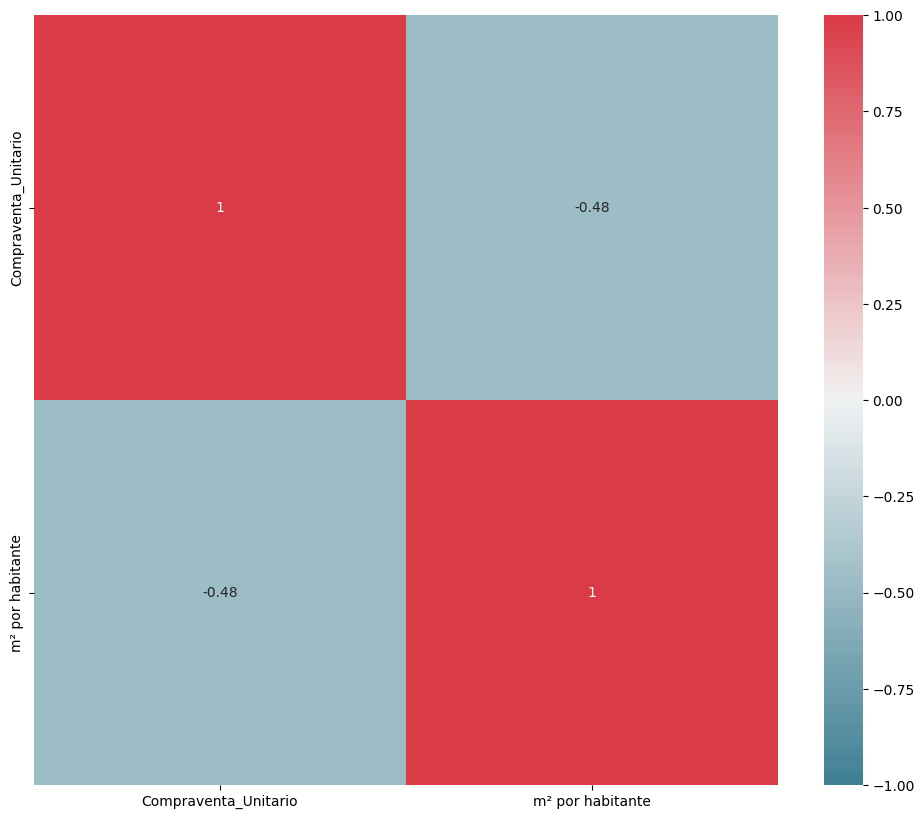

In [ ]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "m² por habitante" es de -0.475285. Esto sugiere una correlación negativa moderada entre estas dos variables. Cuando una variable aumenta, la otra tiende a disminuir, y viceversa, pero no de manera perfectamente lineal.

### Dividir los datos en conjunto de Entrenamiento y Prueba


In [ ]:
fecha_division = '2021-07-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(90, 2) (6, 2)


Los modelos siguientes se ajustarán al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



###Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
cointegration_test(X_train[['Compraventa_Unitario','m² por habitante']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  9.25      > 12.3212   =>   False
m² por habitante >  2.53      > 4.1296    =>   False


* **Compraventa_Unitario**: No hay suficiente evidencia estadística para rechazar la hipótesis nula de no cointegración. Esto sugiere que "Compraventa_Unitario" no tiene una relación de equilibrio estacionario de largo plazo con las otras series en el sistema.
* **m² por habitante**: Similarmente, "m² por habitante" tampoco muestra evidencia de cointegración. No existe una combinación lineal estacionaria que vincule esta serie con otras en el sistema a largo plazo.

Para un análisis conjunto que aún considera las interacciones entre múltiples series no cointegradas, usaremos un modelo VAR (Vector Autoregressive) o VARMA (Vector Autoregressive Moving Average) y descartaremos el modelo VECM (Vector Error Correlation Model), pero primero transformaremos comprobaremos y transformaremos por diferenciacion las veces necesrarias para convertir las series en estacionarias



##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [ ]:
import statsmodels.tsa.stattools as sts

In [ ]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.745433
Serie de tiempo m² por habitante
p-value: 0.926895


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [ ]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,m² por habitante
Fecha,,
2014-02-01,0.000000,0.0
2014-03-01,0.000000,0.0
2014-04-01,121.169231,0.0
2014-05-01,0.000000,0.0
2014-06-01,0.000000,0.0


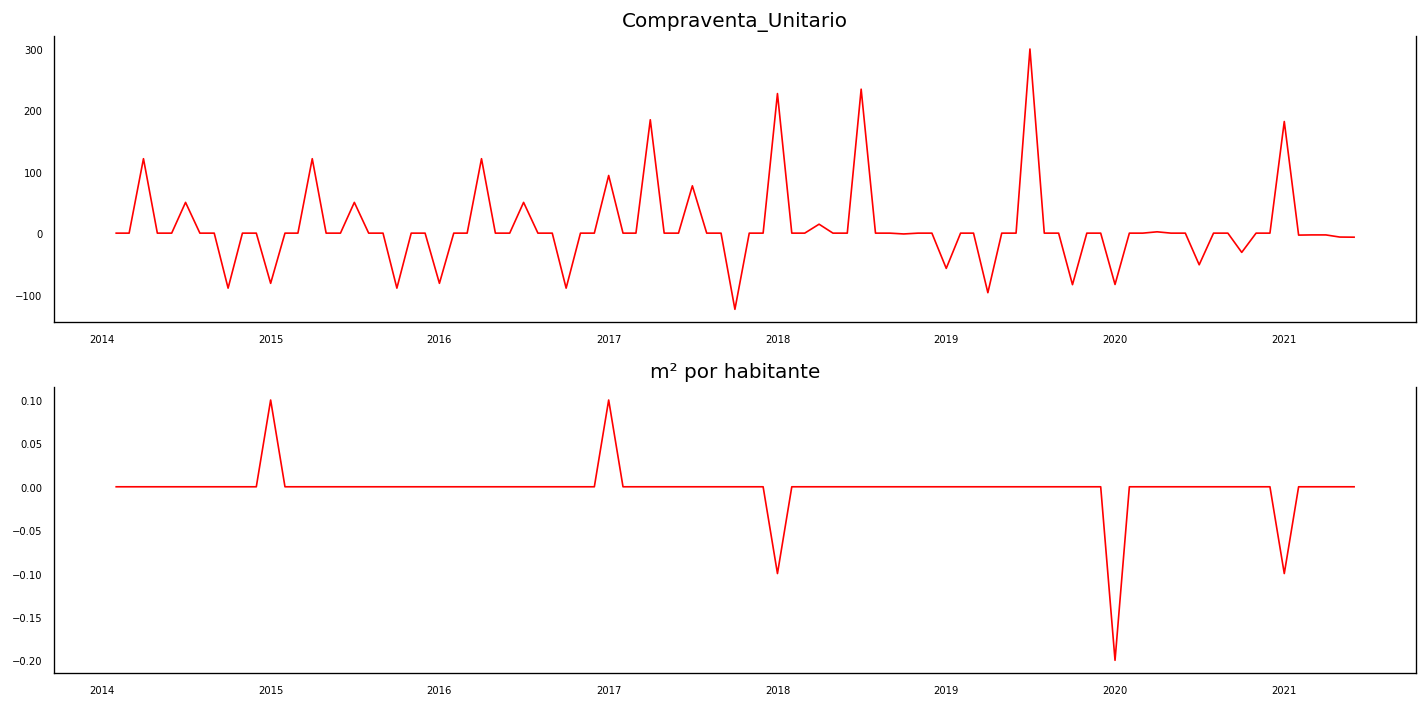

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable m² por habitante
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [ ]:
modelsel=model.select_order(8)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,1.589*,1.648*,4.898*,1.613*
1,1.687,1.865,5.405,1.758
2,1.786,2.081,5.965,1.904
3,1.823,2.237,6.197,1.989
4,1.921,2.453,6.837,2.134
5,2.018,2.668,7.547,2.279
6,1.916,2.684,6.829,2.224
7,2.012,2.899,7.544,2.368
8,2.108,3.114,8.341,2.512


Basado en todos estos criterios, el modelo VAR de orden 0 sería el seleccionado. Esto podría sugerir que las variables no presentan dependencias significativas de sus propios valores pasados o entre sí a intervalos de tiempo anteriores. Sin embargo, este resultado es inusual por lo que se probara con otro select_order. Este resultado tampoco es extraño, dada que la longitud de las series temporales es muy reducida.



In [ ]:
modelsel=model.select_order(12)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,1.510*,1.571*,4.526*,1.534*
1,1.613,1.795,5.017,1.686
2,1.716,2.020,5.562,1.837
3,1.730,2.156,5.645,1.900
4,1.831,2.379,6.254,2.050
5,1.932,2.602,6.931,2.200
6,1.827,2.618,6.255,2.143
7,1.928,2.841,6.945,2.293
8,2.029,3.064,7.717,2.443
9,2.118,3.275,8.489,2.581


#### Ajustando el modelo

In [ ]:
res = model.fit(maxlags=12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     14:06:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.71325
Nobs:                     77.0000    HQIC:                   2.80007
Log likelihood:          -252.882    FPE:                    9.39386
AIC:                      2.19130    Det(Omega_mle):         5.35334
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           13.184232        10.022307            1.315           0.188
L1.Compraventa_Unitario         -0.041224         0.124964           -0.330           0.741
L

En la matriz de correlación de los residuos, observamos que la correlación entre "Compraventa_Unitario" y "m² por habitante" es bastante baja, con un valor de -0.098289. Esto sugiere que los residuos de estas dos variables apenas están correlacionados entre sí después de ajustar el modelo.

In [ ]:
res.is_stable()

True

In [ ]:
X_train.columns

Index(['Compraventa_Unitario', 'm² por habitante'], dtype='object')

###### Causalidad de Granger

In [ ]:
grangercaus=res.test_causality(['m² por habitante'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.8164,1.846,0.633,"(12, 104)"


In [ ]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['m² por habitante'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.4375,1.846,0.945,"(12, 104)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=1
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,m² por habitante_x
Compraventa_Unitario_y,1.0000,0.925
m² por habitante_y,0.9239,1.000


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

#### Diagnosis del modelo


###### Residuos

In [ ]:
residuals=res.resid

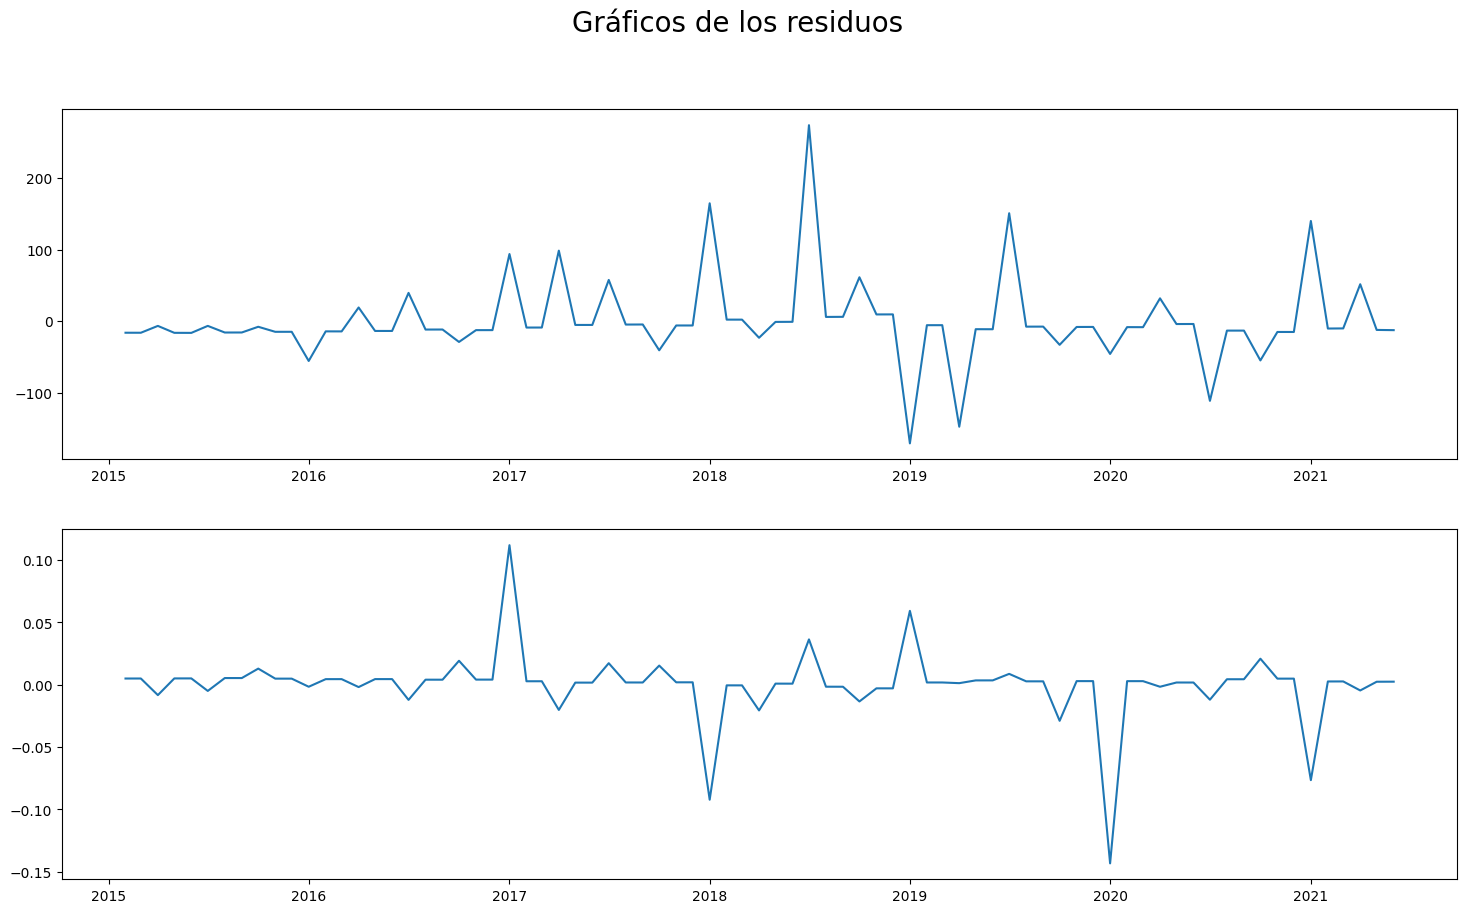

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [ ]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[8.452755579346261e-14, 4.458816791292714e-14]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 3 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


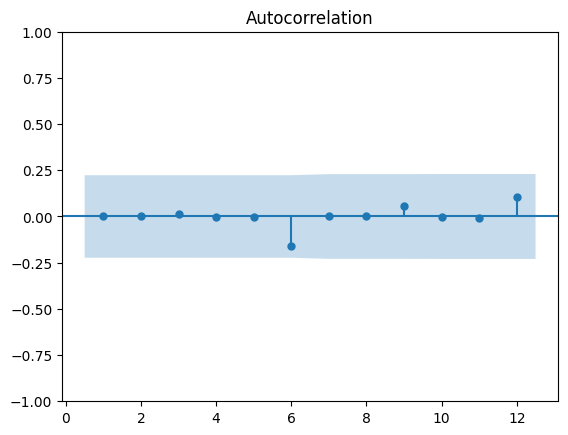

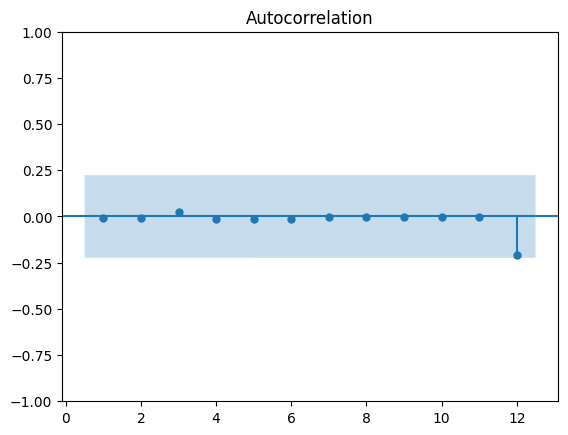

In [ ]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


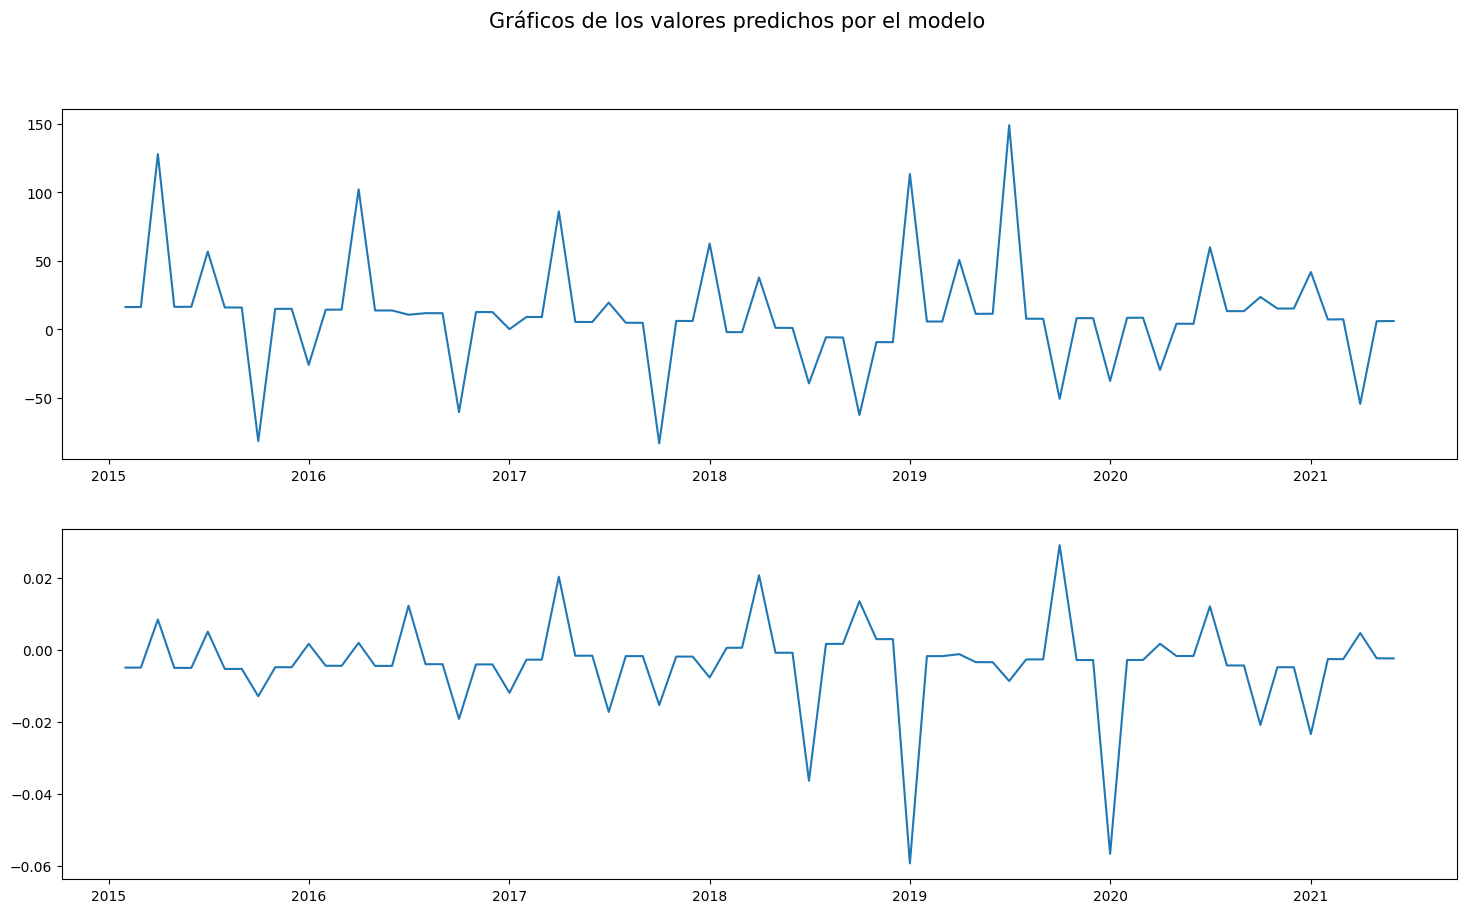

In [ ]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [ ]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=6)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 12
Predicciones:


,Compraventa_Unitario_pred,m² por habitante_pred
Fecha,,
2021-07-01,-79.852402,-0.024506
2021-08-01,8.272424,-0.001954
2021-09-01,7.915887,-0.001913
2021-10-01,46.723890,-0.010741
2021-11-01,3.480710,-0.000387
2021-12-01,3.345661,-0.000287


<Figure size 1200x1000 with 0 Axes>

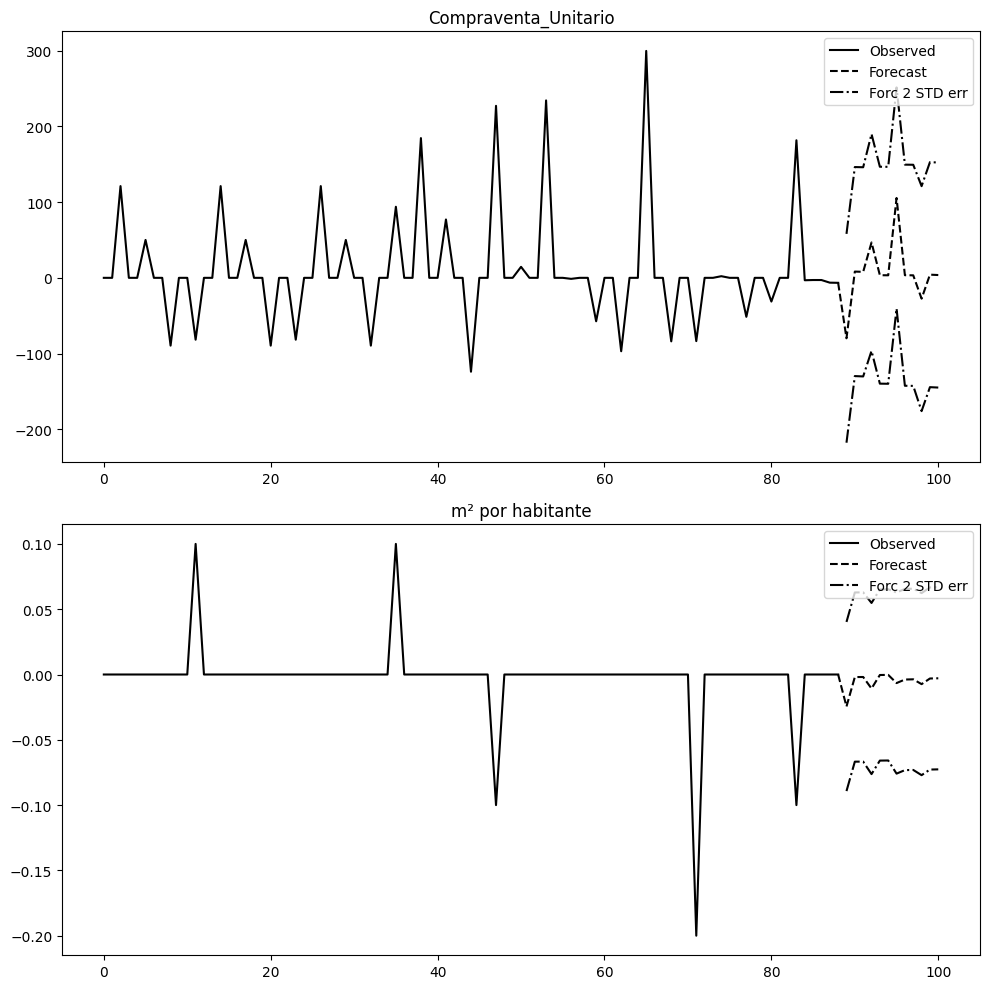

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [ ]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [ ]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,m² por habitante
Fecha,,
2021-07-01,2276.990318,6.675494
2021-08-01,2285.262742,6.673540
2021-09-01,2293.178629,6.671627
2021-10-01,2339.902520,6.660887
2021-11-01,2343.383230,6.660500
2021-12-01,2346.728891,6.660214


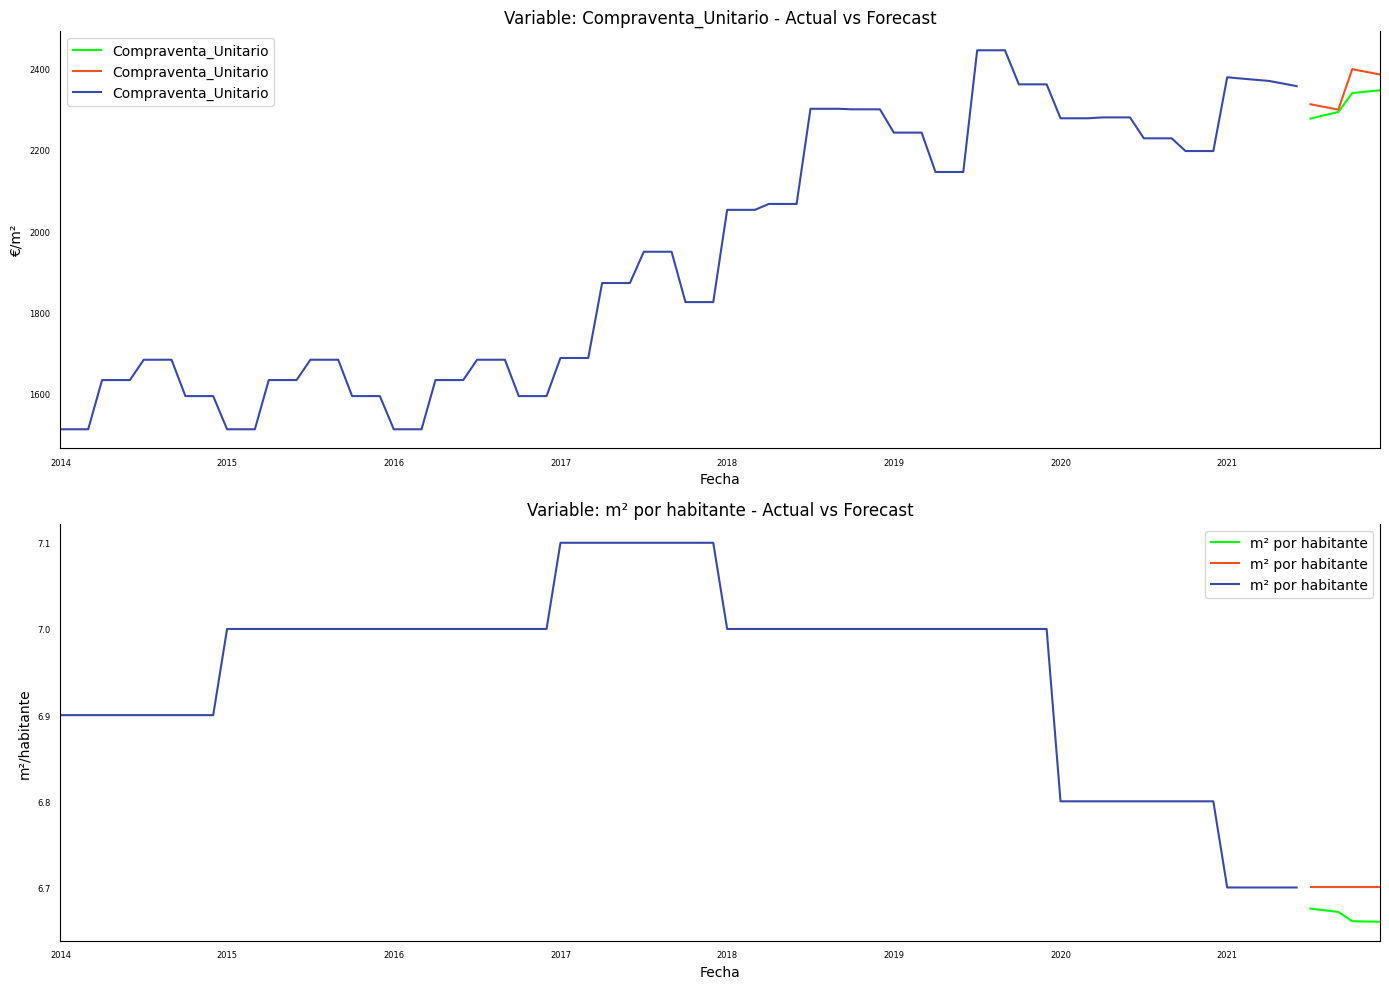

In [ ]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²','m²/habitante']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
for i in ['Compraventa_Unitario','m² por habitante']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 1508.6685020670263
MAE is : 34.69227588276643
RMSE is : 38.84158212620884
MAPE is : 1.4653576209436865
R2 is : 0.20591336216622447

Evaluation metric for m² por habitante
Evaluation metric results:-
MSE is : 0.0011297794198223982
MAE is : 0.032956215036224513
RMSE is : 0.0336121915355485
MAPE is : 0.4918838065108136
R2 is : -1.432165559663364e+27



Los resultados de evaluación para "Compraventa_Unitario" indican que el modelo tiene un error significativo en sus predicciones, con un MSE de 1508.67 y un RMSE de 38.84, sugiriendo desviaciones notables del valor real. El MAE de 34.69 y un R2 de 0.206 también reflejan una precisión moderada y una capacidad limitada del modelo para explicar la variabilidad de los datos. En contraste, para "m² por habitante", los valores de MSE, MAE y RMSE son muy bajos, mostrando errores pequeños, pero un valor R2 extremadamente negativo (aproximadamente -1.43e+27) sugiere problemas con el modelo o la adaptación de la métrica R2 en este contexto específico.

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 17.362616048901327
Root mean squared error: 27.465156397210322


### Modelo VARMA (Auto Arima)

El modelo VARMA (Vector Autoregressive Moving Average) es una técnica estadística utilizada en análisis de series temporales que combina los modelos VAR (Vector Autoregressive) y MA (Moving Average). Es especialmente útil cuando se trata de series temporales múltiples, permitiendo modelar la interdependencia entre varias series a lo largo del tiempo junto con términos de error autocorrelacionados.



In [69]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00


#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [72]:
import pmdarima as pm

In [77]:

pq = []
for name in ['Compraventa_Unitario', 'm² por habitante']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                d=0,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True
                                )
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1006.010, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1008.010, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1008.010, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1010.010, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1006.266, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.504 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : m² por habitante
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-369.707, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-367.707, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-367.707, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-365.707, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-368.209, Time=0.21 sec

Best model:  ARI

In [78]:
pq

[(0, 0, 0), (0, 0, 0)]

- *p=0:* Indica que no hay términos autoregresivos en el modelo. En otras palabras, el modelo VARMAX no incluye dependencia de los valores pasados de las variables en sí mismas.

- *q=0:* Indica que no hay términos de medias móviles en el modelo. Esto significa que no hay dependencia de los errores pasados del modelo en sí mismo.

En este caso no se puede aplicar el modelo VARMAX, ya que el modelo esta considerando unicamente la tendencia lineal y no esta incorporando autocorrelacion en los residuos del modelo.

##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_unitario y m² por habitante de zonas verdes, tenemos que:

- Se ha comprobado que las variables tienen alta correlacion inversa.
- Se ha realizado el test de Cointegracion y se ha demostrado que las series no estan cointegradas, lo que desestima la opcion de aplicar un modelo VECM
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad a partir del segundo orden de diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR y VARMA.
- Modelo VAR: Las metricas de evaluacion del modelo VAR, son bastante satisfactorias para la variable de de zonas verdes, y no tanto para la variable del de valor de compraventa unitario

